# Bulldozer Sale Price Prediction
## 1. Problem defition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. Check data/bluebook-for-bulldozers/Data Dictionary.xlsx

In [242]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy, pandas as pd, seaborn
from sklearn.ensemble import RandomForestRegressor

# Import Train+Validation dataset
data = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", parse_dates=["saledate"], low_memory=False)
data.sort_values(by=["saledate"], inplace=True)
data.info()
#data.head(20)

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')


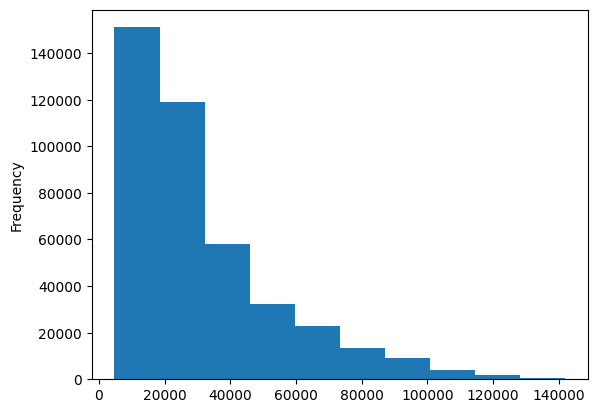

In [101]:
print(data.columns)
data.SalePrice.plot.hist();

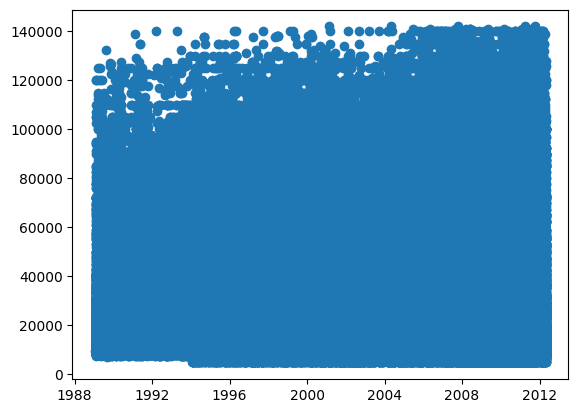

In [102]:
fig, ax = plt.subplots()
ax.scatter(data.saledate, data.SalePrice);

In [103]:
# saledate is a pandas Series of datetime propery
print(f"saledate dtype: {data.saledate.dtype}")
print("\nsaledate info:")
data.saledate.info()
print(f"\nsaledate describe:")
print(data.saledate.describe())
data.state.value_counts()

saledate dtype: datetime64[ns]

saledate info:
<class 'pandas.core.series.Series'>
Index: 412698 entries, 205615 to 409203
Series name: saledate
Non-Null Count   Dtype         
--------------   -----         
412698 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 6.3 MB

saledate describe:
count                           412698
mean     2004-10-19 01:54:17.182733952
min                1989-01-17 00:00:00
25%                2000-12-06 00:00:00
50%                2006-06-28 00:00:00
75%                2009-05-28 00:00:00
max                2012-04-28 00:00:00
Name: saledate, dtype: object


state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virgi

In [230]:
# model.fit() hits "TypeError: Cannot cast DatetimeArray to dtype float32" due to this datetime dtype of 'saledata'
data.saledate.dt.year

data["saleYear"] = data.saledate.dt.year
data["saleMonth"] = data.saledate.dt.month
data["saleDay"] = data.saledate.dt.day
data["saleDayOfWeek"] = data.saledate.dt.dayofweek
data["saleDayOfYear"] = data.saledate.dt.dayofyear

# Now we've enriched our DataFrame with date time features, we can remove 'saledate'
data.drop("saledate", axis=1, inplace=True)

# Convert object dtype to category dtype
for k,v in data.items():
    # v is Series
    if pd.api.types.is_object_dtype(v):
        data[k] = v.astype("category").cat.as_ordered() # This will assign a numerical value to each category
    if pd.isna(v).sum() or pd.isnull(v).sum():
        # Fix missing numerical values        
        if pd.api.types.is_numeric_dtype(v):
            # Add a flag to mark originally missing value
            data[f"{k}_missing"] = pd.isnull(v)
            # Fill missing values with media (NOT mean as mean is more supceptible to outliers)
            data[k] = v.fillna(v.median())
        # Fix missing categorical values
        else:
            # Add a flag to mark originally missing value
            data[f"{k}_missing"] = pd.isnull(v)
            # Turn categories into numbers and +1
            data[k] = pd.Categorical(v).codes + 1 # NULL / N.A will be assigned -1 by default. +1 here will offset all codes by +1. So, Null / N.A will have 0

In [231]:
print("null values:")
data.isna().sum()

null values:


SalesID                      0
SalePrice                    0
MachineID                    0
ModelID                      0
datasource                   0
                            ..
Backhoe_Mounting_missing     0
Blade_Type_missing           0
Travel_Controls_missing      0
Differential_Type_missing    0
Steering_Controls_missing    0
Length: 97, dtype: int64

In [232]:
# Categorical data has a categories and a ordered property, which list their possible values and whether the ordering matters or not. These properties are exposed as s.cat.categories and s.cat.ordered.
data.state.info()
print(f"\nstate categories: {data.state.cat.categories}")
print(f"\nstate categories numerical encodings: {data.state.cat.codes}") # NULL / N.A will be assigned -1 by default.
data.state.value_counts()
data.state

<class 'pandas.core.series.Series'>
Index: 412698 entries, 205615 to 409203
Series name: state
Non-Null Count   Dtype   
--------------   -----   
412698 non-null  category
dtypes: category(1)
memory usage: 3.5 MB

state categories: Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object'

205615         Texas
274835       Florida
141296       Florida
212552       Florida
62755        Florida
             ...    
410879    California
412476    California
411927    California
407124    California
409203    California
Name: state, Length: 412698, dtype: category
Categories (53, object): ['Alabama' < 'Alaska' < 'Arizona' < 'Arkansas' ... 'Washington DC' < 'West Virginia' < 'Wisconsin' < 'Wyoming']

In [233]:
# Categorical data has a categories and a ordered property, which list their possible values and whether the ordering matters or not. These properties are exposed as s.cat.categories and s.cat.ordered.
#print(f"{data.isna().sum()} null values")
#data.info()
data.fiModelDesc.info()
print(f"\nfiModelDesc categories: {data.fiModelDesc.cat.categories}")
print(f"\nfiModelDesc categories numerical encodings: {data.fiModelDesc.cat.codes}") # NULL / N.A will be assigned -1 by default.
data.fiModelDesc.value_counts()[:30]
#data.fiModelDesc

<class 'pandas.core.series.Series'>
Index: 412698 entries, 205615 to 409203
Series name: fiModelDesc
Non-Null Count   Dtype   
--------------   -----   
412698 non-null  category
dtypes: category(1)
memory usage: 4.1 MB

fiModelDesc categories: Index(['100C', '104', '1066', '1066E', '1080', '1080B', '1088', '1088CK',
       '1088LT', '1088TTL',
       ...
       'ZX600LC', 'ZX70', 'ZX75', 'ZX75US', 'ZX75USA', 'ZX80', 'ZX800',
       'ZX800LC', 'ZX80LCK', 'ZX850H'],
      dtype='object', length=5059)

fiModelDesc categories numerical encodings: 205615    4592
274835    1819
141296    2347
212552    1818
62755     2118
          ... 
410879    2100
412476     239
411927     626
407124      82
409203     988
Length: 412698, dtype: int16


fiModelDesc
310G          5348
416C          4976
580K          4364
310E          4296
140G          4186
416B          3765
580L          3481
310D          3443
12G           3270
580SUPER L    3173
753           2883
1845C         2672
420D          2550
966C          2508
210LE         2504
D8K           2457
580           2394
950           2305
763           2102
D8H           2033
416           2014
D6D           1969
D6C           1880
980C          1872
312           1838
225           1804
320CL         1758
555E          1741
140HNA        1675
1840          1619
Name: count, dtype: int64

In [ ]:
# Save preprocessed data so far into csv
data.to_csv("data/bluebook-for-bulldozers/TransAndValid_preprocessed.csv", index=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 97 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   SalesID                           412698 non-null  int64   
 1   SalePrice                         412698 non-null  float64 
 2   MachineID                         412698 non-null  int64   
 3   ModelID                           412698 non-null  int64   
 4   datasource                        412698 non-null  int64   
 5   auctioneerID                      412698 non-null  float64 
 6   YearMade                          412698 non-null  int64   
 7   MachineHoursCurrentMeter          412698 non-null  float64 
 8   UsageBand                         412698 non-null  int8    
 9   fiModelDesc                       412698 non-null  category
 10  fiBaseModel                       412698 non-null  category
 11  fiSecondaryDesc                   41269

In [ ]:
# Extract January 1, 2012 - April 30, 2012 to a validation dataset
data_train = data[data.saleYear != 2012]
print(f"{len(data_train)} data_train")
data_validation = data[data.saleYear == 2012]
print(f"{len(data_validation)} data_validation")

X_train = data_train.drop("SalePrice", axis=1)
Y_train = data_train.SalePrice

X_validation = data_validation.drop("SalePrice", axis=1)
Y_validation = data_validation.SalePrice

X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape

401125 data_train
11573 data_validation

SalePrice.info:
<class 'pandas.core.series.Series'>
Index: 401125 entries, 205615 to 393123
Series name: SalePrice
Non-Null Count   Dtype  
--------------   -----  
401125 non-null  float64
dtypes: float64(1)
memory usage: 6.1 MB

X_train.info:
<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 205615 to 393123
Data columns (total 96 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   SalesID                           401125 non-null  int64   
 1   MachineID                         401125 non-null  int64   
 2   ModelID                           401125 non-null  int64   
 3   datasource                        401125 non-null  int64   
 4   auctioneerID                      401125 non-null  float64 
 5   YearMade                          401125 non-null  int64   
 6   MachineHoursCurrentMeter          401125 non-null  float64 
 7   UsageBand    

205615     9500.0
274835    14000.0
141296    50000.0
212552    16000.0
62755     22000.0
Name: SalePrice, dtype: float64

In [238]:
# The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score
def rmsle(truth, prediction):
    return numpy.sqrt(mean_squared_log_error(truth, prediction))

def Evaluate(model):
    train_predictions = model.predict(X_train, Y_train)
    validation_predictions = model.predict(X_validation, Y_validation)
    scores = {
        "Train R^2": r2_score(Y_train, train_predictions),
        "Validation R^2": r2_score(Y_validation, validation_predictions),
        "Train MAE": mean_absolute_error(Y_train, train_predictions),
        "Validation MAE": mean_absolute_error(Y_validation, validation_predictions),
        "Train RMSLE": rmsle(Y_train, train_predictions),
        "Validation RMSLE": rmsle(Y_validation, validation_predictions)
    }
    return scores

In [239]:
#%%time
#print("\nX_train.info:")
#X_train.info()
#print("\nY_train.info:")
#Y_train.info()
Y_train.head()
model = RandomForestRegressor(n_jobs=-1)
model.fit(X=X_train, y=Y_train)

ValueError: Cannot cast object dtype to float32